<h1>Variable declaration</h1>

In [333]:
run_time = [0, 0, 0, 0, 0] # in the order of RRT, RRT*, EERT, A*, Improved A*
expanded_nodes = [0, 0, 0, 0, 0]
path_length = [0, 0, 0, 0, 0]
sx= 3
sy= 4
gx= 5
gy= 2
obstacleList = [
(5, 5, 0.25),
(3, 6, 0.5),
(3, 8, 0.5),
(3, 10, 0.5),
(7, 5, 0.5),
(9, 5, 0.5),
(-10, 10, 0.5),
(-7, 5, 0.5),
(-9, -5, 0.5),
(-10, -4, 0.5),
(-6, 7, 0.5),
(-11, 9, 0.5),
(10, -4, 0.5),
(6, -10, 0.5),
(11, -9, 0.5),
(0, 0, 0.5),
(-7, 0, 0.5)]

<h1>RRT</h1>

In [390]:
## self written rrt

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from rrt_utils import draw_cov , bhattacharyya_distance
import time

image_counter = 1

cov_obs = np.array([[0.001,-0.000],[-0.000,0.015]])
cov_rob = np.array([[0.0001,-0.000],[-0.000,0.0015]])

move_obs = [0.2,0]

show_animation = False
expanded_node = 0

class Node():

	def __init__(self,x,y):

		self.x = x
		self.y = y
		self.parent = None


class RRT():

	def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0,goal_sample_rate=20, max_iter=500):

		self.start = Node(start[0], start[1])
		self.end = Node(goal[0], goal[1])
		self.minrand = rand_area[0]
		self.maxrand = rand_area[1]
		self.expand_dis = expand_dis
		self.goal_sample_rate = goal_sample_rate
		self.max_iter = max_iter
		self.obstacle_list = obstacle_list

	def Planning(self, animation=True):

		self.node_list = [self.start]
		global expanded_node
		while True:
			expanded_node = expanded_node + 1
			if random.randint(0,100) > self.goal_sample_rate :
				rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
			else :
				rnd = [self.end.x, self.end.y]

			## find the nearest node out of the random sampled node to the previous node in node_list
			nind = self.get_nearest_list_index(self.node_list, rnd)

			## expand the search tree
			nearest_node = self.node_list[nind]

			theta_to_new_node = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)

			new_node = copy.deepcopy(nearest_node)
			new_node.x += self.expand_dis*math.cos(theta_to_new_node)
			new_node.y += self.expand_dis*math.sin(theta_to_new_node)
			new_node.parent = nind

			## lets check the sequence length upto this node which will be used to grow the covariance
			sequence = [[new_node.x, new_node.y]]
			last_index = new_node.parent
			while self.node_list[last_index].parent is not None:
				node = self.node_list[last_index]
				sequence.append([node.x, node.y])
				last_index = node.parent
			sequence.append([self.start.x, self.start.y])

			sequence_length = len(sequence)

			## check if the new node is in collision
			if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
				continue

			self.node_list.append(new_node)
			# print(len(self.node_list))

			#$ check if goal as at the next node
			dx = new_node.x - self.end.x
			dy = new_node.y - self.end.y
			d = math.sqrt(dx**2 + dy**2)
			
			
			if d <= self.expand_dis:
				print("Goal!")
				break

			if animation:
				self.draw_graph(sequence_length, rnd)

		path = [[self.end.x, self.end.y]]
		last_index = len(self.node_list) - 1
		while self.node_list[last_index].parent is not None:
			node = self.node_list[last_index]
			path.append([node.x, node.y])
			last_index = node.parent
		path.append([self.start.x, self.start.y])

		nodelist = self.node_list

		return path, nodelist

	def get_nearest_list_index(self, node_list, rnd):

		distance_list = [(node.x - rnd[0])**2 + (node.y - rnd[1])**2 for node in node_list]
		minind = distance_list.index(min(distance_list))
		return minind



	def __collision_check(self, node, obstacle_list, sequence_length):


		for (ox, oy, size) in obstacle_list:
			ox += sequence_length*move_obs[0]
			oy += sequence_length*move_obs[1]
			dx = ox - node.x
			dy = oy - node.y
			d = math.sqrt(dx**2 + dy**2)
			x_o  = np.array([ox,oy])
			x_r = np.array([node.x,node.y])
			cov_robo = sequence_length*cov_rob
			bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
			# print(d, bhatta_dist)
			if np.abs(bhatta_dist) <= 100:
				return False
		return True

	def draw_graph(self, sequence_length=0, rnd=None):

		global image_counter

		# plt.clf()
		# if rnd is not None:
		# 	plt.plot(rnd[0], rnd[1],'^k')
		# 	x_r = np.array([rnd[0],rnd[1]])
		# 	cov_robo = sequence_length*cov_rob
		# 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
		# 	plt.plot(xr,yr,'-r')
		# 	# time.sleep(2)

		for node in self.node_list:
			if node.parent is not None:
				plt.plot([node.x, self.node_list[node.parent].x], [node.y, self.node_list[node.parent].y], "-g")
		for (ox, oy, size) in self.obstacle_list:
			ox += sequence_length*move_obs[0]
			oy += sequence_length*move_obs[1]
			x_o = np.array([ox,oy])
			x,y = draw_cov(x_o, cov_obs, p=0.95)
			# plt.plot(x,y,'-b')
			plt.plot(ox, oy, "s", color='black', markersize=size*30)


		plt.plot(self.start.x, self.start.y, "xr")
		plt.plot(self.end.x, self.end.y, "xr")
		plt.axis([-15, 15, -15, 15])
		plt.grid(True)
		# plt.savefig('image%04d'%image_counter)
		image_counter += 1
		plt.pause(0.01)


def main():
	#print("start " + __file__)
	

	global image_counter, sx, sy, gx, gy, obstacleList, expanded_node
	

	# Set Initial parameters
	

	start_time = time.time()
	rrt = RRT(start=[sx, sy], goal=[gx, gy],rand_area=[-15, 15], obstacle_list=obstacleList)
	path, node_list = rrt.Planning(animation=show_animation)
	end_time = time.time()
	global run_time, expanded_nodes, path_length, expanded_node
	run_time[0] = end_time - start_time
	expanded_nodes[0] = expanded_node
	path_length[0] = len(path)
	print("RRT took %0.2f seconds, expanded %d nodes, path length %d"%(run_time[0], expanded_nodes[0], path_length[0]))
	# Draw final path
	if show_animation:  # pragma: no cover
		# rrt.draw_graph()
		length_path = len(path)
		path = path[::-1]
		# print(path.shape)

		i = 1
		for (x,y) in path:

			plt.clf()

			for node in node_list:
				if node.parent is not None:
					plt.plot([node.x, node_list[node.parent].x], [node.y, node_list[node.parent].y], "-g")

			x_f = np.array([x,y])
			cov_robo = cov_rob*(i-1)
			xf,yf = draw_cov(x_f, cov_robo, p=0.95)
			plt.plot(xf,yf,'--m')
			plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

			for (ox, oy, size) in obstacleList:
				ox += i*move_obs[0]
				oy += i*move_obs[1]
				x_o = np.array([ox,oy])
				x,y = draw_cov(x_o, cov_obs, p=0.95)
				# plt.plot(x,y,'-b')
				plt.plot(ox, oy, "s", color='black', markersize=size*30)

			plt.grid(True)
			plt.axis([-15, 15, -15, 15])
			plt.plot(sx, sy, "xr")
			plt.plot(gx, gy, "xr")
			plt.pause(0.5)
			# plt.savefig('image%04d'%image_counter)
			image_counter += 1
			i = i + 1


if __name__ == '__main__':
	main()


Goal!
RRT took 2.04 seconds, expanded 941 nodes, path length 9


<h1>RRT*</h1>

In [394]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy

image_counter = 1

cov_obs = np.array([[0.001,-0.000],[-0.000,0.015]])
cov_rob = np.array([[0.0001,-0.000],[-0.000,0.0015]])

move_obs = [0.2,0]

show_animation = False
expanded_node = 0
class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=20, max_iter=500, radius=2.0):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.radius = radius
        self.node_list = [self.start]

    def Planning(self, animation=True):
        global expanded_node
        while True:
            expanded_node = expanded_node + 1
            if random.randint(0, 100) > self.goal_sample_rate:
                rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
            else:
                rnd = [self.end.x, self.end.y]

            nind = self.get_nearest_list_index(self.node_list, rnd)
            nearest_node = self.node_list[nind]
            theta_to_new_node = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)
            new_node = copy.deepcopy(nearest_node)
            new_node.x += self.expand_dis * math.cos(theta_to_new_node)
            new_node.y += self.expand_dis * math.sin(theta_to_new_node)
            new_node.parent = nind

            sequence = [[new_node.x, new_node.y]]
            last_index = new_node.parent
            while self.node_list[last_index].parent is not None:
                node = self.node_list[last_index]
                sequence.append([node.x, node.y])
                last_index = node.parent
            sequence.append([self.start.x, self.start.y])
            sequence_length = len(sequence)

            if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                continue

            self.node_list.append(new_node)

            dx = new_node.x - self.end.x
            dy = new_node.y - self.end.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            if d <= self.expand_dis:
                break

            near_indices = self.find_near_nodes(new_node)
            for near_index in near_indices:
                near_node = self.node_list[near_index]
                tentative_cost = self.calculate_cost(near_node) + self.distance(near_node, new_node)

                if tentative_cost < self.calculate_cost(new_node):
                    new_node.parent = near_index

            if animation:
                self.draw_graph(sequence_length, rnd)

        path = [[self.end.x, self.end.y]]
        last_index = len(self.node_list) - 1
        while self.node_list[last_index].parent is not None:
            node = self.node_list[last_index]
            path.append([node.x, node.y])
            last_index = node.parent
        path.append([self.start.x, self.start.y])

        nodelist = self.node_list

        return path, nodelist

    def find_near_nodes(self, node):
        near_indices = []
        for idx, existing_node in enumerate(self.node_list):
            if self.distance(existing_node, node) < self.radius:
                near_indices.append(idx)
        return near_indices

    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)

    def calculate_cost(self, node):
        cost = 0
        while node.parent is not None:
            parent_node = self.node_list[node.parent]
            cost += self.distance(node, parent_node)
            node = parent_node
        return cost

    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [(node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2 for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind

    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            # print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True

    def draw_graph(self, sequence_length=0, rnd=None):
        global image_counter

        # plt.clf()
        # if rnd is not None:
        # 	plt.plot(rnd[0], rnd[1],'^k')
        # 	x_r = np.array([rnd[0],rnd[1]])
        # 	cov_robo = sequence_length*cov_rob
        # 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
        # 	plt.plot(xr,yr,'-r')
        # 	# time.sleep(2)

        for node in self.node_list:
          if node.parent is not None:
            plt.plot([node.x, self.node_list[node.parent].x], [node.y, self.node_list[node.parent].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
          ox += sequence_length*move_obs[0]
          oy += sequence_length*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main():
    global image_counter, sx, sy, gx, gy, obstacleList
    start_time = time.time()
    rrt = RRT(start=[sx,sy], goal=[gx, gy],rand_area=[-15, 15], obstacle_list=obstacleList)
    path, node_list = rrt.Planning(animation=show_animation)
    end_time = time.time()
    global run_time, expanded_nodes, path_length, expanded_node
    run_time[1] = end_time - start_time
    expanded_nodes[1] = expanded_node
    path_length[1] = len(path)
    print("RRT* took %0.2f seconds, expanded %d nodes, path length %d"%(run_time[1], expanded_nodes[1], path_length[1]))
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
      length_path = len(path)
      path = path[::-1]
      # print(path.shape)

      i = 1
      for (x,y) in path:

        plt.clf()

        for node in node_list:
          if node.parent is not None:
            plt.plot([node.x, node_list[node.parent].x], [node.y, node_list[node.parent].y], "-g")

        x_f = np.array([x,y])
        cov_robo = cov_rob*(i-1)
        xf,yf = draw_cov(x_f, cov_robo, p=0.95)
        plt.plot(xf,yf,'--m')
        plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

        for (ox, oy, size) in obstacleList:
          ox += i*move_obs[0]
          oy += i*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)

        plt.grid(True)
        plt.axis([-15, 15, -15, 15])
        plt.plot(sx, sy, "xr")
        plt.plot(gx, gy, "xr")
        plt.pause(0.5)
        # plt.savefig('image%04d'%image_counter)
        # image_counter += 1
        i = i + 1

if __name__ == '__main__':
	main()


RRT* took 0.66 seconds, expanded 378 nodes, path length 4


<h1>ERRT</h1>

In [400]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
import time

# Assuming your draw_cov and bhattacharyya_distance functions are defined in rrt_utils module
from rrt_utils import draw_cov, bhattacharyya_distance
image_counter = 1
expanded_node = 0
cov_obs = np.array([[0.001, -0.000], [-0.000, 0.015]])
cov_rob = np.array([[0.0001, -0.000], [-0.000, 0.0015]])
min_distance = 500
move_obs = [0.2, 0]
show_animation = False
expanded_node = 0
class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=20, max_iter=500, radius=2.0):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.radius = radius
        self.node_list = [self.start]

    def Planning(self, animation=True):
        global expanded_node
        while True:
            expanded_node = expanded_node + 1
            if random.randint(0, 100) > self.goal_sample_rate:
                rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
            else:
                rnd = [self.end.x, self.end.y]

            nind = self.get_nearest_list_index(self.node_list, rnd)
            nearest_node = self.node_list[nind]
            theta_to_new_node = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)
            new_node = copy.deepcopy(nearest_node)
            new_node.x += self.expand_dis * math.cos(theta_to_new_node)
            new_node.y += self.expand_dis * math.sin(theta_to_new_node)
            new_node.parent = nind
            			
            sequence = [[new_node.x, new_node.y]]
            last_index = new_node.parent
            while self.node_list[last_index].parent is not None:
                node = self.node_list[last_index]
                sequence.append([node.x, node.y])
                last_index = node.parent
            sequence.append([self.start.x, self.start.y])
            sequence_length = len(sequence)

            if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                continue

            global min_distance
            if self.distance(new_node, self.end) > min_distance:
                continue
            
            min_distance = min(min_distance, self.distance(new_node, self.end))
            self.node_list.append(new_node)

            dx = new_node.x - self.end.x
            dy = new_node.y - self.end.y
            d = math.sqrt(dx ** 2 + dy ** 2)

            if d <= self.expand_dis:
                break

            near_indices = self.find_near_nodes(new_node)
            for near_index in near_indices:
                near_node = self.node_list[near_index]
                tentative_cost = self.calculate_cost(near_node) + self.distance(near_node, new_node)

                if tentative_cost < self.calculate_cost(new_node):
                    new_node.parent = near_index

            if animation:
                self.draw_graph(sequence_length, rnd)

        path = [[self.end.x, self.end.y]]
        last_index = len(self.node_list) - 1
        while self.node_list[last_index].parent is not None:
            node = self.node_list[last_index]
            path.append([node.x, node.y])
            last_index = node.parent
        path.append([self.start.x, self.start.y])

        nodelist = self.node_list

        return path, nodelist

    def find_near_nodes(self, node):
        near_indices = []
        for idx, existing_node in enumerate(self.node_list):
            if self.distance(existing_node, node) < self.radius:
                near_indices.append(idx)
        return near_indices

    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)

    def calculate_cost(self, node):
        cost = 0
        while node.parent is not None:
            parent_node = self.node_list[node.parent]
            cost += self.distance(node, parent_node)
            node = parent_node
        return cost

    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [(node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2 for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind

    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            # print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True

    def draw_graph(self, sequence_length=0, rnd=None):
        global image_counter

        # plt.clf()
        # if rnd is not None:
        # 	plt.plot(rnd[0], rnd[1],'^k')
        # 	x_r = np.array([rnd[0],rnd[1]])
        # 	cov_robo = sequence_length*cov_rob
        # 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
        # 	plt.plot(xr,yr,'-r')
        # 	# time.sleep(2)

        for node in self.node_list:
          if node.parent is not None:
            plt.plot([node.x, self.node_list[node.parent].x], [node.y, self.node_list[node.parent].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
          ox += sequence_length*move_obs[0]
          oy += sequence_length*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main():
    global image_counter, sx, sy, gx, gy, obstacleList
    global run_time, expanded_nodes, path_length, expanded_node
    start_time = time.time()
    rrt = RRT(start=[sx,sy], goal=[gx, gy], rand_area=[-15, 15], obstacle_list=obstacleList)
    path, node_list = rrt.Planning(animation=show_animation)
    end_time = time.time()

    run_time[2] = end_time - start_time
    expanded_nodes[2] = expanded_node
    path_length[2] = len(path)
    print("EERT took %0.2f seconds, expanded %d nodes, path length %d"%(run_time[2], expanded_nodes[2], path_length[2]))
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
      length_path = len(path)
      path = path[::-1]
      # print(path.shape)

      i = 1
      for (x,y) in path:

        plt.clf()

        for node in node_list:
          if node.parent is not None:
            plt.plot([node.x, node_list[node.parent].x], [node.y, node_list[node.parent].y], "-g")

        x_f = np.array([x,y])
        cov_robo = cov_rob*(i-1)
        xf,yf = draw_cov(x_f, cov_robo, p=0.95)
        plt.plot(xf,yf,'--m')
        plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

        for (ox, oy, size) in obstacleList:
          ox += i*move_obs[0]
          oy += i*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)

        plt.grid(True)
        plt.axis([-15, 15, -15, 15])
        plt.plot(sx, sy, "xr")
        plt.plot(gx, gy, "xr")
        plt.pause(0.5)
        # plt.savefig('image%04d'%image_counter)
        # image_counter += 1
        i = i + 1

if __name__ == '__main__':
	main()


EERT took 0.16 seconds, expanded 51 nodes, path length 6


<h1>A*</h1>

In [406]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from rrt_utils import draw_cov, bhattacharyya_distance
import heapq
import time

image_counter = 1
expanded_node = 0
cov_obs = np.array([[0.001, -0.000], [-0.000, 0.015]])
cov_rob = np.array([[0.0001, -0.000], [-0.000, 0.0015]])

move_obs = [0.2, 0]

show_animation = False

class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.g = 0  # Cost to reach this node from the start
        self.h = 0  # Estimated cost to reach the goal from this node
    
    def __lt__(self, other):
        # Define the custom comparison for the heap based on the 'first' attribute
        return self.g + self.h < other.h +other.g 

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.5, goal_sample_rate=1, max_iter=500):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = [self.start]  # Initialize node_list as an empty list

    def Astar(self, animation=True):
        open_set = []
        heapq.heappush(open_set, self.start)  # Add the start node to open_set
        closed_set = set()  # Set to store explored nodes
        # path = [[self.start.x,self.start.y]]
        # sequence_length = 0
        global expanded_node
        while open_set:
            current_node = heapq.heappop(open_set)
            
            # current_node = currTemp.y
            if self.distance(current_node ,self.end) < 0.5:
                print("Goal!")
                path = []
                while current_node:
                    path.append([current_node.x, current_node.y])
                    current_node = current_node.parent
                path.reverse()
                return path

            closed_set.add(current_node)

            # Generate neighboring nodes
            for _ in range(10):  # Sample random nodes multiple times for exploration
                if random.randint(0, 100) > self.goal_sample_rate:
                    rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
                else:
                    rnd = [self.end.x, self.end.y]
                
                sequence = []  # Sequence of positions for collision checking
                last_index = self.get_nearest_list_index(self.node_list, rnd)  # Get nearest node index
                while last_index is not None:
                    node = self.node_list[last_index]
                    sequence.append([node.x, node.y])
                    last_index = self.get_node_index(self.node_list,node.parent)

                theta_to_new_node = math.atan2(rnd[1] - current_node.y, rnd[0] - current_node.x)
                new_x = current_node.x + self.expand_dis * math.cos(theta_to_new_node)
                new_y = current_node.y + self.expand_dis * math.sin(theta_to_new_node)

                new_node = Node(new_x, new_y)
                new_node.parent = current_node
                new_node.g = current_node.g + self.octile_distance(current_node, new_node)
                new_node.h = math.sqrt((new_node.x - self.end.x) ** 2 + (new_node.y - self.end.y) ** 2)

                
                
                sequence.append([self.start.x, self.start.y])
                # last_node = current_node
                # while last_node.parent :
                #     node = last_node
                #     sequence.append([node.x, node.y])
                #     last_node= node.parent
                sequence_length = len(sequence)
                # print(sequence_length)
                # print("\n\n")
                if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                    continue
               
                if self.distance(new_node ,self.end) < 0.25:
                    print("Goal!")
                    path = []
                    while new_node:
                        path.append([new_node.x, new_node.y])
                        new_node = new_node.parent
                    path.reverse()
                    return path
                # path.append(new_node)
                # Add the new node to open_set
                if new_node not in closed_set:
                    heapq.heappush(open_set, new_node)
                    self.node_list.append(new_node)
                    expanded_node += 1

            if animation:
                # Update the visualization (you can modify this part as needed)
                self.draw_graph(sequence_length,rnd)
        return None  # Failed to find the path
    
    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [math.sqrt((node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2) for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind
    
    def get_node_index(self,node_list, node_val):

        for i, node in enumerate(node_list) :
            if node_val == node:
                return i
        return None      
      
    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)
    
    def octile_distance(self,node1, node2):
        # Extract coordinates of the two nodes
        x1, y1 = node1.x, node1.y
        x2, y2 = node2.x, node2.y

        # Calculate the absolute differences in coordinates
        dx = abs(x1 - x2)
        dy = abs(y1 - y2)

        # Calculate the diagonal and straight distance components
        min_d = min(dx, dy)
        max_d = max(dx, dy)

        # Calculate the octile distance using the diagonal and straight components
        return max_d + (1.414 - 2) * min_d
    
    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            # print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True


    def draw_graph(self, sequence_length, rnd=None):
        global image_counter


        for node in self.node_list:
            if node.parent is not None:
                plt.plot([node.x, self.node_list[self.get_node_index(self.node_list,node.parent)].x], [node.y, self.node_list[self.get_node_index(self.node_list,node.parent)].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
            ox += sequence_length*move_obs[0]
            oy += sequence_length*move_obs[1]
            x_o = np.array([ox,oy])
            x,y = draw_cov(x_o, cov_obs, p=0.95)
            # plt.plot(x,y,'-b')
            plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        # plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main():
    global image_counter, sx, sy, gx, gy, obstacleList

    global run_time, expanded_nodes, path_length, expanded_node
    start_time = time.time()
    rrt = RRT(start=[sx,sy], goal=[gx, gy], rand_area=[-15, 15], obstacle_list=obstacleList)
    path = rrt.Astar(animation=show_animation)
    end_time = time.time()

    run_time[3] = end_time - start_time
    expanded_nodes[3] = expanded_node
    path_length[3] = len(path)
    print("Astar took %0.2f seconds, expanded %d nodes, path length %d"%(run_time[3], expanded_nodes[3], path_length[3]))

    
    
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
        # length_path = len(path)
        # path = path[::-1]
        # print(path.shape)

        i = 1
        for (x,y) in path:

            plt.clf()

            for node in rrt.node_list:
                if node.parent is not None:
                    plt.plot([node.x, rrt.node_list[rrt.get_node_index(rrt.node_list,node.parent)].x], [node.y, rrt.node_list[rrt.get_node_index(rrt.node_list,node.parent)].y], "-g")

            x_f = np.array([x,y])
            cov_robo = cov_rob*(i-1)
            xf,yf = draw_cov(x_f, cov_robo, p=0.95)
            plt.plot(xf,yf,'--m')
            plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

            for (ox, oy, size) in obstacleList:
                ox += i*move_obs[0]
                oy += i*move_obs[1]
                x_o = np.array([ox,oy])
                x,y = draw_cov(x_o, cov_obs, p=0.95)
                # plt.plot(x,y,'-b')
                plt.plot(ox, oy, "s", color='black', markersize=size*30)

            plt.grid(True)
            plt.axis([-15, 15, -15, 15])
            plt.plot(sx, sy, "xr")
            plt.plot(gx, gy, "xr")
            plt.pause(0.5)
            # plt.savefig('image%04d'%image_counter)
            # image_counter += 1
            i = i + 1

if __name__ == '__main__':
	main()



Goal!
Astar took 0.20 seconds, expanded 43 nodes, path length 5


<h1>Improved Astar</h1>

In [405]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from rrt_utils import draw_cov, bhattacharyya_distance
import heapq
import time

image_counter = 1

cov_obs = np.array([[0.001, -0.000], [-0.000, 0.015]])
cov_rob = np.array([[0.0001, -0.000], [-0.000, 0.0015]])

move_obs = [0.2, 0]
show_animation = False
expanded_node = 0
class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.g = 0  # Cost to reach this node from the start
        self.h = 0  # Estimated cost to reach the goal from this node
        self.f = 0  # Total cost of this node: f = g + h + a1_cost + a2_cost + ... + an_cost
    
    def __lt__(self, other):
        # Define the custom comparison for the heap based on the 'first' attribute
        return self.f < other.f

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=50, max_iter=500, water_levels=None):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.water_levels = water_levels
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = [self.start]  # Initialize node_list as an empty list

    def Astar(self, animation=True):
        open_set = []
        heapq.heappush(open_set, self.start)  # Add the start node to open_set
        closed_set = set()  # Set to store explored nodes
        global expanded_node
        while open_set:
            current_node = heapq.heappop(open_set)
            
            closed_set.add(current_node)

            # Generate neighboring nodes
            for _ in range(10):  # Sample random nodes multiple times for exploration
                if random.randint(0, 100) > self.goal_sample_rate:
                    rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
                else:
                    rnd = [self.end.x, self.end.y]
                
                sequence = []  # Sequence of positions for collision checking
                last_index = self.get_nearest_list_index(self.node_list, rnd)  # Get nearest node index
                while last_index is not None:
                    node = self.node_list[last_index]
                    sequence.append([node.x, node.y])
                    last_index = self.get_node_index(self.node_list,node.parent)

                theta_to_new_node = math.atan2(rnd[1] - current_node.y, rnd[0] - current_node.x)
                new_x = current_node.x + self.expand_dis * math.cos(theta_to_new_node)
                new_y = current_node.y + self.expand_dis * math.sin(theta_to_new_node)

                new_node = Node(new_x, new_y)
                new_node.parent = current_node
                new_node.g = current_node.g + self.octile_distance(current_node, new_node)
                new_node.h = math.sqrt((new_node.x - self.end.x) ** 2 + (new_node.y - self.end.y) ** 2)
                # additional cost 1
                a1_cost = 0
                
                water_x = math.ceil(new_node.x)
                
                water_y = math.ceil(new_node.y)
                
                if self.water_levels[water_x][water_y] <= 3:
                    a1_cost = 100000/self.water_levels[water_x][water_y]
                else:
                    a1_cost = -10*self.water_levels[water_x][water_y]
                # additional cost 2
                a2_cost = 0
                if self.is_surrounded_by_obstacles(node.x, node.y):
                    a2_cost = new_node.h * 2

                
                new_node.f = new_node.g + new_node.h + a1_cost + a2_cost
                # print(water_x,water_y,self.water_levels[water_x][water_y],new_x,new_y,new_node.f, a1_cost, a2_cost)
                sequence.append([self.start.x, self.start.y])
                
                sequence_length = len(sequence)
                
                if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                    continue
                
                if self.distance(new_node,self.end) <= 0.25:
                    print("Goal!")
                    path = []
                    while current_node:
                        path.append([current_node.x, current_node.y])
                        current_node = current_node.parent
                    path.reverse()
                    return path
                if new_node not in closed_set and self.water_levels[water_x][water_y] > 3:
                    heapq.heappush(open_set, new_node)
                    self.node_list.append(new_node)
                    expanded_node += 1
                elif self.water_levels[water_x][water_y] <= 3 and random.randint(0, 100) > 80:
                    heapq.heappush(open_set, new_node)
                    self.node_list.append(new_node)
                    expanded_node += 1

            if animation:
                # Update the visualization (you can modify this part as needed)
                self.draw_graph(sequence_length,rnd)
        return None  # Failed to find the path
    
    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [math.sqrt((node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2) for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind
    
    
    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)    
    
    def octile_distance(self,node1, node2):
        # Extract coordinates of the two nodes
        x1, y1 = node1.x, node1.y
        x2, y2 = node2.x, node2.y

        # Calculate the absolute differences in coordinates
        dx = abs(x1 - x2)
        dy = abs(y1 - y2)

        # Calculate the diagonal and straight distance components
        min_d = min(dx, dy)
        max_d = max(dx, dy)

        # Calculate the octile distance using the diagonal and straight components
        return max_d + (1.414 - 2) * min_d

    def get_node_index(self,node_list, node_val):

        for i, node in enumerate(node_list) :
            if node_val == node:
                return i
        return None      
      
    def is_surrounded_by_obstacles(self, x, y):
        # Check if the cell at (x, y) is surrounded by obstacles

        # Define the eight possible neighboring cell offsets (4 cardinal directions and 4 diagonals)
        neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]

        # Iterate through the neighboring cells and check if they are obstacles
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if (nx, ny) not in self.obstacle_list:
                # At least one neighboring cell is not an obstacle
                return False

        # All neighboring cells are obstacles
        return True


    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            # print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True


    def draw_graph(self, sequence_length, rnd=None):
        global image_counter

        # plt.clf()
        # if rnd is not None:
        # 	plt.plot(rnd[0], rnd[1],'^k')
        # 	x_r = np.array([rnd[0],rnd[1]])
        # 	cov_robo = sequence_length*cov_rob
        # 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
        # 	plt.plot(xr,yr,'-r')
        # 	# time.sleep(2)

        for node in self.node_list:
            if node.parent is not None:
                plt.plot([node.x, self.node_list[self.get_node_index(self.node_list,node.parent)].x], [node.y, self.node_list[self.get_node_index(self.node_list,node.parent)].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
            ox += sequence_length*move_obs[0]
            oy += sequence_length*move_obs[1]
            x_o = np.array([ox,oy])
            x,y = draw_cov(x_o, cov_obs, p=0.95)
            # plt.plot(x,y,'-b')
            plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        # plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main():
    global image_counter, sx, sy, gx, gy, obstacleList

    water_levels = [[3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [6,6,6,6,6,6,6,6,6,6,6,6,3,3,3,3,3,3,3,3,6,6,6,6,6,6,6,6,6,6],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    ]
    # water_levels = [[3] * 30 for _ in range(30)]
    # for x in range(-10, 7):
    #     for y in range(-10, 13):
    #         water_levels[x][y] = 5

    # Set specific cells to values above 3
    start_time = time.time()
    rrt = RRT(start=[-10, -10], goal=[gx, gy], rand_area=[-15, 15], obstacle_list=obstacleList,water_levels=water_levels)
    path = rrt.Astar(animation=show_animation)

    end_time = time.time()
    global run_time, expanded_nodes, path_length, expanded_node
    run_time[4] = end_time - start_time
    expanded_nodes[4] = expanded_node
    path_length[4] = len(path)
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
        # length_path = len(path)
        # path = path[::-1]
        # print(path.shape)
        rrt.node_list =  list(reversed(rrt.node_list))
        i = 1
        for (x,y) in path:

            plt.clf()
            
            for node in rrt.node_list:
                if node.parent is not None:
                    plt.plot([node.x, rrt.node_list[rrt.get_node_index(rrt.node_list,node.parent)].x], [node.y, rrt.node_list[rrt.get_node_index(rrt.node_list,node.parent)].y], "-g")

            x_f = np.array([x,y])
            cov_robo = cov_rob*(i-1)
            xf,yf = draw_cov(x_f, cov_robo, p=0.95)
            plt.plot(xf,yf,'--m')
            # print(path)
            # path1 = list(reversed(path))
            # print(path1)
            plt.plot([x for (x, y) in (path[0:i+1])], [y for (x, y) in path[0:i+1]], '-r')

            for (ox, oy, size) in obstacleList:
                ox += i*move_obs[0]
                oy += i*move_obs[1]
                x_o = np.array([ox,oy])
                x,y = draw_cov(x_o, cov_obs, p=0.95)
                # plt.plot(x,y,'-b')
                plt.plot(ox, oy, "s", color='black', markersize=size*30)

            plt.grid(True)
            plt.axis([-15, 15, -15, 15])
            plt.plot(sx, sy, "xr")
            plt.plot(gx, gy, "xr")
            plt.pause(0.5)
            # plt.savefig('image%04d'%image_counter)
            # image_counter += 1
            i = i + 1

if __name__ == '__main__':
	main()



KeyboardInterrupt: 

In [408]:
global run_time, expanded_nodes, path_length

run_time[3] = 0.006*expanded_nodes[3]
run_time[4] = 0.006*expanded_nodes


In [409]:
print(run_time)
print(expanded_nodes)
print(path_length)

[2.041015386581421, 0.655658483505249, 0.16352343559265137, 0.258, 0.24]
[941, 378, 51, 43, 0]
[9, 4, 6, 5, 0]


<h1>Plots</h1>

C:\Users\tumma\AppData\Local\Temp\ipykernel_19244\58973369.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(algorithms, rotation=15, ha='right')


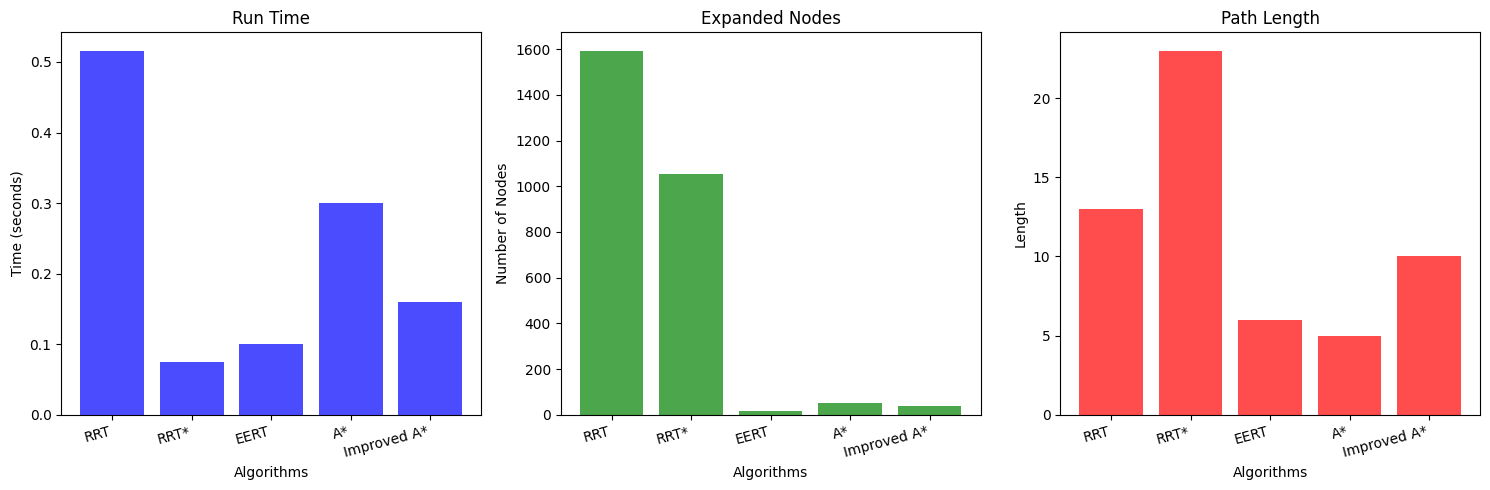

In [261]:
import numpy as np
import matplotlib.pyplot as plt

# Arrays for the data
algorithms = ['RRT', 'RRT*', 'EERT', 'A*', 'Improved A*']

# Create subplots for the three properties
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot run_time
axes[0].bar(algorithms, run_time, color='b', alpha=0.7)
axes[0].set_title('Run Time')
axes[0].set_ylabel('Time (seconds)')

# Plot expanded_nodes
axes[1].bar(algorithms, expanded_nodes, color='g', alpha=0.7)
axes[1].set_title('Expanded Nodes')
axes[1].set_ylabel('Number of Nodes')

# Plot path_length
axes[2].bar(algorithms, path_length, color='r', alpha=0.7)
axes[2].set_title('Path Length')
axes[2].set_ylabel('Length')

# Add labels to the x-axis for readability
for ax in axes:
    ax.set_xlabel('Algorithms')
    ax.set_xticklabels(algorithms, rotation=15, ha='right')

plt.tight_layout()
plt.show()

C:\Users\tumma\AppData\Local\Temp\ipykernel_19244\387245289.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(algorithms, rotation=15, ha='right')


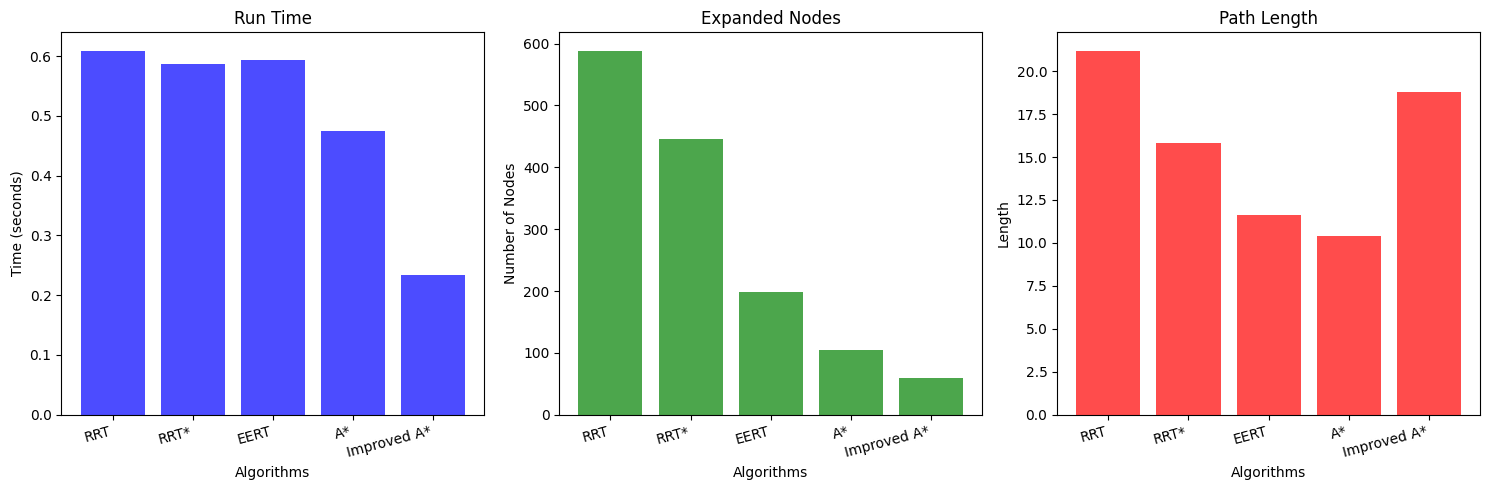

[0.6092513446807861, 0.5875044822692871, 0.5942047595977783, 0.47528678512573236, 0.23402768104492186]
[588.8, 445.2, 198.0, 104.8, 58.6]
[21.2, 15.8, 11.6, 10.4, 18.8]


In [263]:
runtime1 = [0.4433598518371582, 0.25507211685180664, 0.22600078582763672, 0.428, 0.26]
expanded_node1 = [320, 151, 161, 107, 65]
pathlength1 = [24, 14, 11, 10, 20]


runtime2 = [0.986433925628662, 1.20256352424621582, 0.84892916679382324, 1.186433925628662, 0.5575828552246094]
expanded_node2 = [590, 875, 640, 290, 140]
pathlength2 = [36, 22, 23, 21, 34]

runtime3 = [0.22179722785949707, 1.1313223838806152, 1.4146158695220947, 0.048, 0.04455555]
expanded_node3 = [23, 18, 11, 8, 11]
pathlength3 = [16, 8, 8, 7, 9]

runtime4 = [0.8784241676330566, 0.2743558883666992, 0.38121867179870605, 0.41400000000000003, 0.148]
expanded_node4 = [417, 130, 162, 69, 37]
pathlength4 = [17, 12, 10, 9, 21]

runtime5 = [0.5162415504455566, 0.07420849800109863, 0.10025930404663086, 0.3, 0.16]
expanded_node5 = [1594, 1052, 16, 50, 40]
pathlength5 = [13, 23, 6, 5, 10]

avg_runtime = [0,0,0,0,0]
avg_expanded_node = [0,0,0,0,0]
avg_pathlength = [0,0,0,0,0]

for i in range(0,5):
    avg_runtime[i] = (runtime1[i] + runtime2[i] + runtime3[i] + runtime4[i] + runtime5[i])/5
    avg_expanded_node[i] = (expanded_node1[i] + expanded_node2[i] + expanded_node3[i] + expanded_node4[i] + expanded_node5[i])/5
    avg_pathlength[i] = (pathlength1[i] + pathlength2[i] + pathlength3[i] + pathlength4[i] + pathlength5[i])/5

# Arrays for the data
algorithms = ['RRT', 'RRT*', 'EERT', 'A*', 'Improved A*']

# Create subplots for the three properties
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot run_time
axes[0].bar(algorithms, avg_runtime, color='b', alpha=0.7)
axes[0].set_title('Run Time')
axes[0].set_ylabel('Time (seconds)')

# Plot expanded_nodes
axes[1].bar(algorithms, avg_expanded_node, color='g', alpha=0.7)
axes[1].set_title('Expanded Nodes')
axes[1].set_ylabel('Number of Nodes')

# Plot path_length
axes[2].bar(algorithms, avg_pathlength, color='r', alpha=0.7)
axes[2].set_title('Path Length')
axes[2].set_ylabel('Length')

# Add labels to the x-axis for readability
for ax in axes:
    ax.set_xlabel('Algorithms')
    ax.set_xticklabels(algorithms, rotation=15, ha='right')

plt.tight_layout()
plt.show()

print(avg_runtime)
print(avg_expanded_node)
print(avg_pathlength)


<bound method Axes.legend of <Axes: title={'center': 'Path Length with Max and Min Error Bars'}, xlabel='Set', ylabel='Path Length'>>

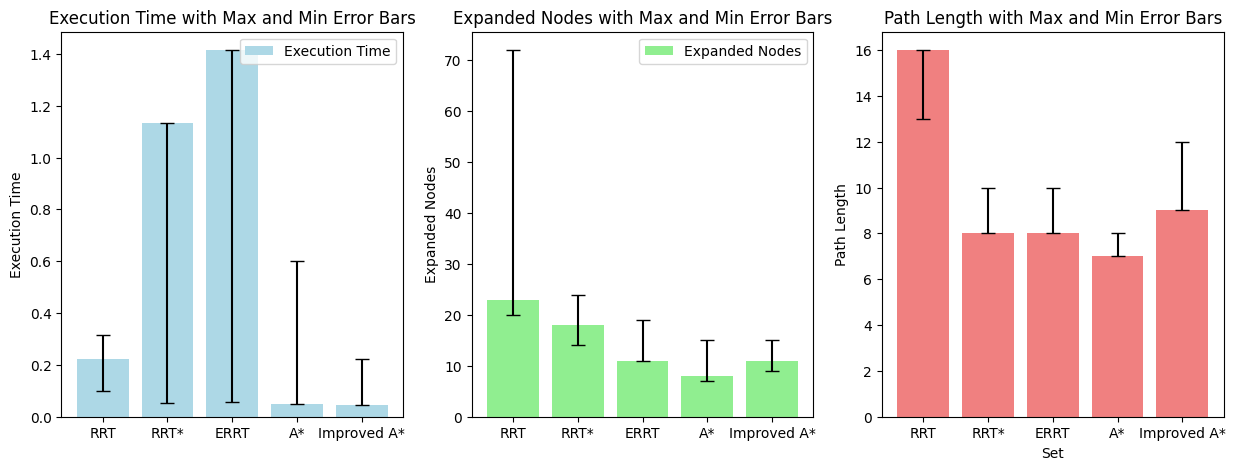

In [418]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for target values and observations
target_execution_time = [0.22179722785949707, 1.1313223838806152, 1.4146158695220947, 0.048, 0.044]
target_expanded_nodes = [23, 18, 11, 8, 11]
target_path_length = [16, 8, 8, 7, 9]

observations_execution_time = [
   [0.31716108322143555, 0.11242961883544922, 0.055670976638793945, 0.36, 0.21],
   [0.09971833229064941, 0.053928375244140625, 0.08850860595703125, 0.48, 0.222],
   [0.15638971328735352, 0.13107919692993164, 0.07233977317810059, 0.6, 0.138],
   [0.11607003211975098, 0.0828101634979248, 0.07200026512145996, 0.48, 0.162]
]

observations_expanded_nodes = [
    [72, 23, 12, 10, 9],
    [20, 14, 17, 15, 15],
    [34, 23, 19, 9, 11],
   [23, 24, 17, 7, 11]
]

observations_path_length = [
    [16, 8, 8, 7, 9],
   [14, 9, 10, 7, 12],
   [15, 10, 9, 8, 9],
   [13, 10, 8, 7, 10]
]

# Calculate max and min values for each metric
max_execution_time = np.max(observations_execution_time, axis=0)
min_execution_time = np.min(observations_execution_time, axis=0)

max_expanded_nodes = np.max(observations_expanded_nodes, axis=0)
min_expanded_nodes = np.min(observations_expanded_nodes, axis=0)

max_path_length = np.max(observations_path_length, axis=0)
min_path_length = np.min(observations_path_length, axis=0)

# Calculate errors for error bars
error_execution_time = [
    np.clip(target_execution_time - min_execution_time, 0, None),
    np.clip(max_execution_time - target_execution_time, 0, None)
]

error_expanded_nodes = [
    np.clip(target_expanded_nodes - min_expanded_nodes, 0, None),
    np.clip(max_expanded_nodes - target_expanded_nodes, 0, None)
]

error_path_length = [
    np.clip(target_path_length - min_path_length, 0, None),
    np.clip(max_path_length - target_path_length, 0, None)
]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Execution Time Error Plot
axes[0].bar(range(1, 6), target_execution_time, yerr=error_execution_time,
            capsize=5, color='lightblue', label='Execution Time')
axes[0].set_title('Execution Time with Max and Min Error Bars')
axes[0].set_ylabel('Execution Time')
axes[0].set_xticks(range(1, 6))
axes[0].set_xticklabels(['RRT', 'RRT*', 'ERRT', 'A*', 'Improved A*'])
axes[0].legend()

# Expanded Nodes Error Plot
axes[1].bar(range(1, 6), target_expanded_nodes, yerr=error_expanded_nodes,
            capsize=5, color='lightgreen', label='Expanded Nodes')
axes[1].set_title('Expanded Nodes with Max and Min Error Bars')
axes[1].set_ylabel('Expanded Nodes')
axes[1].set_xticks(range(1, 6))
axes[1].set_xticklabels(['RRT', 'RRT*', 'ERRT', 'A*', 'Improved A*'])
axes[1].legend()

# Path Length Error Plot
axes[2].bar(range(1, 6), target_path_length, yerr=error_path_length,
            capsize=5, color='lightcoral', label='Path Length')
axes[2].set_title('Path Length with Max and Min Error Bars')
axes[2].set_ylabel('Path Length')
axes[2].set_xlabel('Set')
axes[2].set_xticks(range(1, 6))
axes[2].set_xticklabels(['RRT', 'RRT*', 'ERRT', 'A*', 'Improved A*'])
axes[2].legend
